### Demo notebook for Maup's smart_repair function for fixing topological problems in shapefiles

In [1]:
import pandas as pd
import geopandas as gpd

from geopandas import GeoSeries, GeoDataFrame

import shapely
from shapely.geometry import Polygon

import maup
from maup import smart_repair, quick_repair

import matplotlib.pyplot as plt


### First we'll explore a toy example of "precincts" and "counties":

In [2]:
import random
random.seed(2023) # For reproducibility

ppolys = []

for i in range(4):
    for j in range(4):
        poly = Polygon(
            [(0.5*i + 0.1*k, 0.5*j + (random.random() - 0.5)/12) for k in range(6)] +
            [(0.5*(i+1) + (random.random() - 0.5)/12, 0.5*j + 0.1*k) for k in range(1,6)] +
            [(0.5*(i+1) - 0.1*k, 0.5*(j+1) + (random.random() - 0.5)/12) for k in range(1,6)] +
            [(0.5*i + (random.random() - 0.5)/12, 0.5*(j+1) - 0.1*k) for k in range(1,5)]
        )
        ppolys.append(poly)
        
toy_precincts_df = gpd.GeoDataFrame(geometry = gpd.GeoSeries(ppolys))

<Axes: >

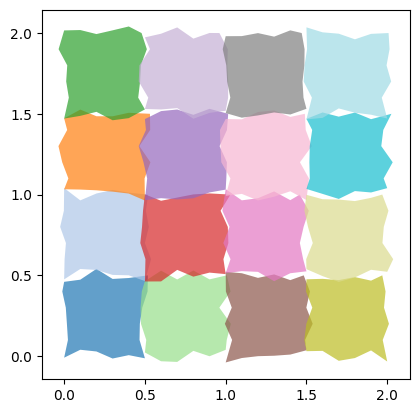

In [3]:
toy_precincts_df.plot(cmap='tab20', alpha=0.7)

### Check for gaps and overlaps:

In [4]:
maup.doctor(toy_precincts_df)

There are 28 overlaps.
There are 23 holes.


False

### First do a basic repair of the toy precincts:

In [5]:
toy_precincts_repaired_df = smart_repair(toy_precincts_df)

Snapping all geometries to a grid with precision 10^( -10 ) to avoid GEOS errors.
Identifying overlaps...
Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


Gaps to fill: 100%|█████████████████████████████| 10/10 [00:00<00:00, 16.40it/s]


### Check that the repair succeeded:

In [6]:
maup.doctor(toy_precincts_repaired_df)

True

<Axes: >

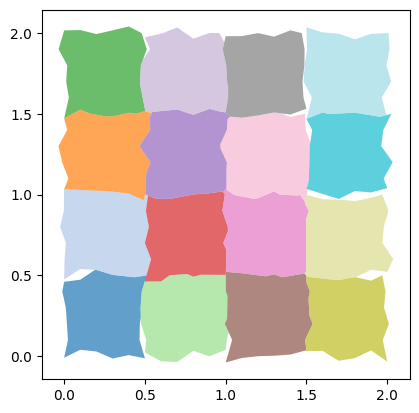

In [7]:
toy_precincts_repaired_df.plot(cmap='tab20', alpha=0.7)

### Now suppose that the precincts are intended to nest cleanly into the following "toy counties:"

In [8]:
cpoly1 = Polygon([(0,0), (1,0), (1,1), (0,1)])
cpoly2 = Polygon([(1,0), (2,0), (2,1), (1,1)])
cpoly3 = Polygon([(0,1), (1,1), (1,2), (0,2)])
cpoly4 = Polygon([(1,1), (2,1), (2,2), (1,2)])

toy_counties_df = gpd.GeoDataFrame(geometry = gpd.GeoSeries([cpoly1, cpoly2, cpoly3, cpoly4]))

<Axes: >

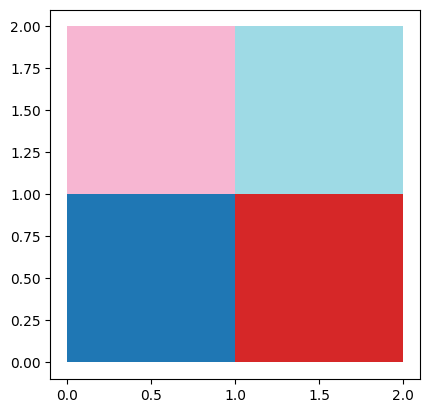

In [9]:
toy_counties_df.plot(cmap='tab20')

### We can perform a "county-aware" repair as follows:

Snapping all geometries to a grid with precision 10^( -10 ) to avoid GEOS errors.
Identifying overlaps...
Resolving overlaps and filling gaps...


Gaps to fill in region 3: 100%|███████████████████| 5/5 [00:00<00:00, 18.95it/s]


<Axes: >

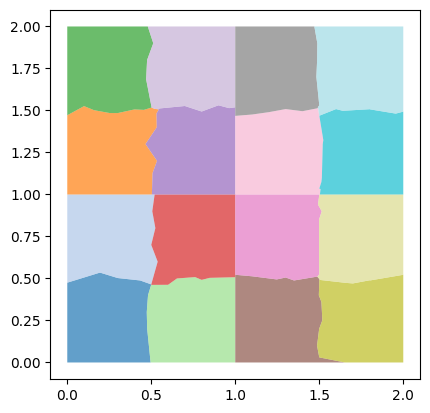

In [10]:
toy_precincts_repaired_county_aware_df = smart_repair(toy_precincts_df, nest_within_regions = toy_counties_df)
toy_precincts_repaired_county_aware_df.plot(cmap = "tab20", alpha=0.7)

### Next, suppose that we'd like to get rid of small rook adjacencies at corner points where 4 precincts meet. We might reasonably estimate that these all have length less than 0.1, so we can accomplish this as follows:

Snapping all geometries to a grid with precision 10^( -10 ) to avoid GEOS errors.
Identifying overlaps...
Resolving overlaps and filling gaps...


Gaps to fill in region 3: 100%|███████████████████| 5/5 [00:00<00:00, 19.08it/s]


Converting small rook adjacencies to queen...


<Axes: >

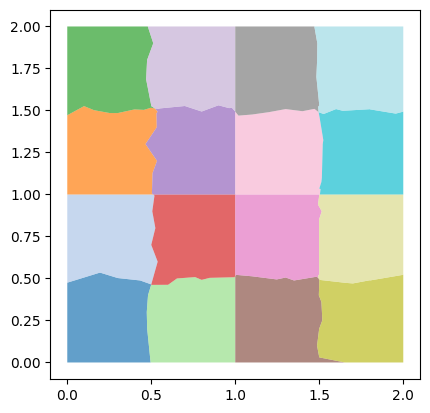

In [11]:
toy_precincts_repaired_county_aware_rook_to_queen_df = smart_repair(toy_precincts_df, nest_within_regions = toy_counties_df, min_rook_length = 0.1)
toy_precincts_repaired_county_aware_rook_to_queen_df.plot(cmap = "tab20", alpha=0.7)

### The difference is hard to see, so let's zoom in on gap between the 4 original precincts in the upper left-hand corner.

### Original precincts:

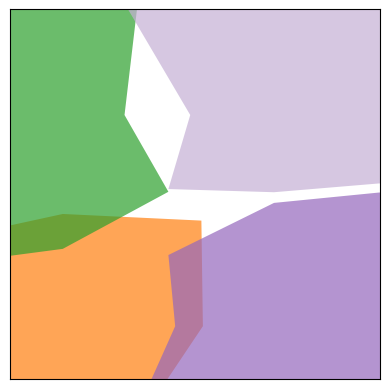

In [12]:
f, ax = plt.subplots(1)

ax.set_xlim(0.35, 0.7)
ax.set_ylim(1.35, 1.7)
#remove x axis and y axis
plt.yticks([])
plt.xticks([])

toy_precincts_df.plot(ax=ax, cmap='tab20', alpha=0.7)

plt.box(on=True)

plt.show()



### County-aware repair:

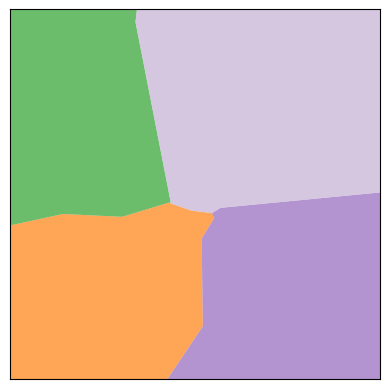

In [13]:
f, ax = plt.subplots(1)

ax.set_xlim(0.35, 0.7)
ax.set_ylim(1.35, 1.7)
#remove x axis and y axis
plt.yticks([])
plt.xticks([])

toy_precincts_repaired_county_aware_df.plot(ax=ax, cmap='tab20', alpha=0.7)

plt.box(on=True)

plt.show()


### County-aware repair with rook adjacency converted to queen

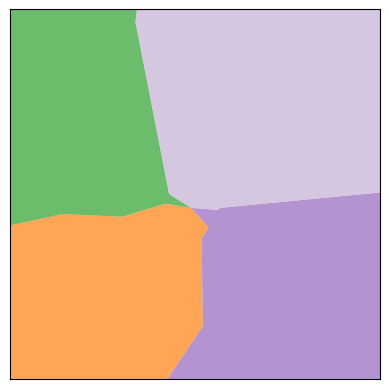

In [14]:
f, ax = plt.subplots(1)

ax.set_xlim(0.35, 0.7)
ax.set_ylim(1.35, 1.7)
#remove x axis and y axis
plt.yticks([])
plt.xticks([])

toy_precincts_repaired_county_aware_rook_to_queen_df.plot(ax=ax, cmap='tab20', alpha=0.7)

plt.box(on=True)

plt.show()


### Now let's look a particularly gnarly gap from the Colorado 2020 precinct shapefile.  This region consists of 15 precincts that all adjoin a single gap along a county boundary.

In [15]:
bad_gap_region_df = gpd.read_file("../examples/Shapefiles/bad_gap_region/bad_gap_region.shp")

<Axes: >

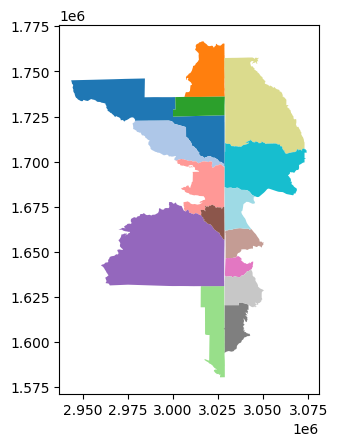

In [16]:
bad_gap_region_df.plot(cmap='tab20')

### The gap is hard to see, so let's stretch it out:

<Axes: >

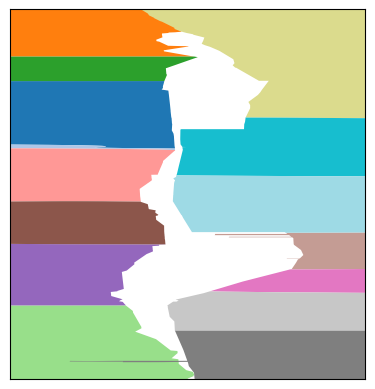

In [17]:
f, ax = plt.subplots(1)

plt.yticks([])
plt.xticks([])

plt.xlim([3028000, 3029500])
plt.ylim([1600000, 1756000])

bad_gap_region_df.plot(ax=ax, cmap='tab20', aspect=0.01)

### Maup's old "autorepair" function (now called "quick_repair") will assign this entire gap to a single precinct, thereby creating inaccurate adjacency relations between precincts adjoining the gap:

In [18]:
bad_gap_region_quick_repair_df = quick_repair(bad_gap_region_df)

/Users/jnc/Research and Presentations/Gerrymandering and elections/Maup stuff/maup_2_0_0/repair.py:384: UserWarning: The indices of the two GeoSeries are different.
  result = targets.union(sources_to_absorb)
/Users/jnc/Research and Presentations/Gerrymandering and elections/Maup stuff/maup_2_0_0/repair.py:384: UserWarning: The indices of the two GeoSeries are different.
  result = targets.union(sources_to_absorb)


<Axes: >

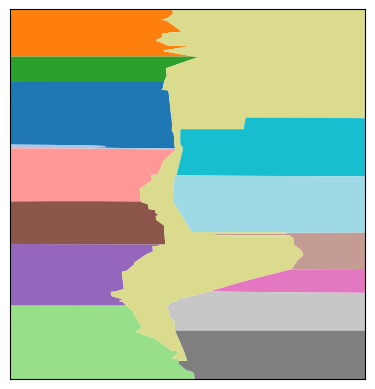

In [19]:
f, ax = plt.subplots(1)

plt.yticks([])
plt.xticks([])

plt.xlim([3028000, 3029500])
plt.ylim([1600000, 1756000])

bad_gap_region_quick_repair_df.plot(ax=ax, cmap='tab20', aspect=0.01)

### The "smart_repair" function does a much better job:

In [20]:
bad_gap_region_smart_repair_df = smart_repair(bad_gap_region_df)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...
Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to fill: 100%|███████████████████████████████| 1/1 [00:04<00:00,  4.98s/it]


<Axes: >

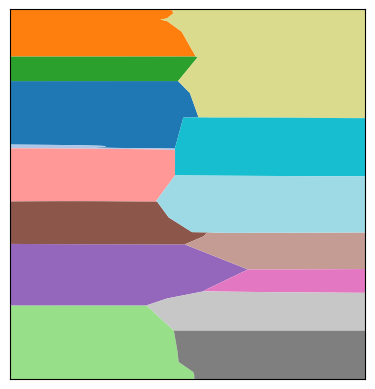

In [21]:
f, ax = plt.subplots(1)

plt.yticks([])
plt.xticks([])

plt.xlim([3028000, 3029500])
plt.ylim([1600000, 1756000])

bad_gap_region_smart_repair_df.plot(ax=ax, cmap='tab20', aspect=0.01)